# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [91]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [92]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [93]:
# add any additional libaries you need here

import nltk
nltk.download('brown')
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package brown to C:\Users\Luis
[nltk_data]     Perez\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [94]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [95]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [96]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [97]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

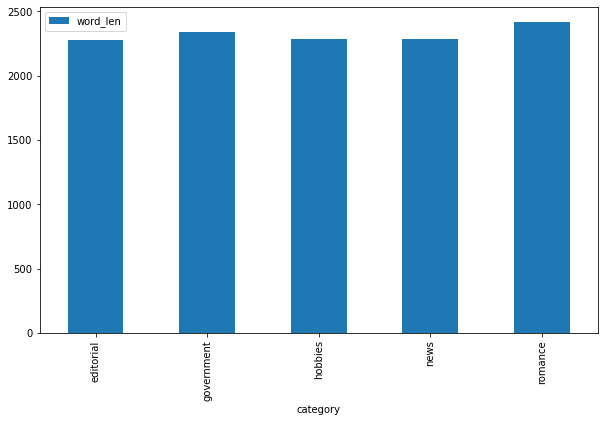

In [98]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [99]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

D:\python\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [100]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count text vector is as its name states a vector of word counts. this vector transforms the df[text] into a numerical representation. This vector ignores stopwords, sets a min of word repetition of 5, and a maximum fraction of a word appearing.

While tfidf_text_vectors performs a similar task of turning the df[text] column into a numerical representation but using the TF-IDF technique. This technique in other words takes each word and assigns a weight depending on how often it shows in the document (TF term frequency and IDF inverse document frequency).


## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [101]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_nmf_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_nmf_text_matrix = nmf_text_model.components_

D:\python\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [102]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [103]:
df['assigned_topic'] = [np.argmax(row) for row in W_nmf_text_matrix]

nmf_topic_counts = {}
for category in categories:
    nmf_topic_counts[category] = [0, 0, 0, 0, 0]
    for i in range(len(df)):
        if df['category'][i] == category:
            nmf_topic_counts[category][df['assigned_topic'][i]] += 1

nmf_topic_counts

{'editorial': [20, 4, 2, 0, 1],
 'government': [4, 0, 26, 0, 0],
 'news': [8, 0, 11, 17, 8],
 'romance': [0, 29, 0, 0, 0],
 'hobbies': [0, 8, 26, 1, 1]}

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Our NMF model performed poorly compared to the original brown categories. For Topic 0, it categorized correctly most of the articles as editorial(20) with very few exceptions leaking into the government(4) and news (2). Topic 1, had trouble correctly classifying articles as government. For this topic, NMF model misclassified all articles into other topics with most articles labeled romance. Topic 2 had trouble labeling articles as news. Instead, NMF spread the articles between government (17), hobbies(11), and news(8) categories. Topic 3, mislabelled all categories into news. Finally, topic 4 also misclassified all the articles into news instead of hobbies.    

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [104]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_

In [105]:
df['assigned_topic'] = [np.argmax(row) for row in W_lsa_text_matrix]

lsa_topic_counts = {}
for category in categories:
    lsa_topic_counts[category] = [0, 0, 0, 0, 0]
    for i in range(len(df)):
        if df['category'][i] == category:
            lsa_topic_counts[category][df['assigned_topic'][i]] += 1



In [106]:
lsa_topic_counts

{'editorial': [27, 0, 0, 0, 0],
 'government': [30, 0, 0, 0, 0],
 'news': [34, 0, 0, 3, 7],
 'romance': [21, 8, 0, 0, 0],
 'hobbies': [36, 0, 0, 0, 0]}

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model performed well when comparing to the original Brown categories. Topic 0, 1, and 4 labeled all the articles into the corresponding Brown labeled category editorial, government, and hobbies respectevy. Topic 2, mostly captured all articles as news(34) with only a few going into romance(3) and hobbies(7). Topic 3, also captured most into the correct romance category with only 8 articles misclassified.

In [107]:
# call display_topics on your model

display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: From the display topics (LSA) I can see that topics 0 and 1 would be a challenge since they have similar and overlapping words. Topic 2 has Kennedy and Khrushchev as topics that could mislead into labeling as government or news. Topics 03 and 04 at first glance seem to be related to sports, where depending on who wrote the articles can fall into romance or hobbies categories. Overall, it shows how this is not a straightforward task and correctly labeling each article is a difficult task. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [108]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [109]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [110]:
df['assigned_topic'] = [np.argmax(row) for row in W_lda_text_matrix]

lda_topic_counts = {}
for category in categories:
    lda_topic_counts[category] = [0, 0, 0, 0, 0]
    for i in range(len(df)):
        if df['category'][i] == category:
            lda_topic_counts[category][df['assigned_topic'][i]] += 1

lda_topic_counts

{'editorial': [3, 1, 21, 2, 0],
 'government': [1, 12, 3, 4, 10],
 'news': [4, 3, 32, 3, 2],
 'romance': [28, 0, 1, 0, 0],
 'hobbies': [11, 9, 2, 8, 6]}

Q: What inference do you draw from the displayed topics for your LDA model? 

A: From the start, I can see that LDA will have trouble correctly classifying compared to Brown categories. The displayed topics seem to have captured words that don't give out a topic by themselves. All topics seemed to spread out into many topics or categories

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: From the observations on the displayed topics, seems that LDA was not able to correctly categorize most of the topics. The only category that LDA seems to have been able to correctly label is topic 3 where it correctly categorized most of the articles as romance. Other than that all other topics were spread into multiple categories.    

In [111]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)


In [112]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: From the principal component, scatterplot we can see how each topic is represented by a circle and the space or position between is how similar a topic is according to our LDA model. An initial observation we can make is that each topic is spaced from the other alluding to the model correctly grouping distinct topics. Topic 1 and 3 in the scatterplot show how both topics were similar to each other.

On the other hand, the salient term graph provides a thorough overview of the terms that are most closely related to each topic and the relationships between all of the topics. We can observe that some words, such as "state", "said", and "states" are used in several different topics and are pertinent to many different topics by scrolling through the topics. Each word's relative importance in a given issue is indicated by its bar size. As a result, the graph offers a thorough perspective of the connections between each topic and the words that are related to it.
